In [148]:
from pathlib import Path
from datetime import datetime, timedelta
from functools import reduce
from operator import add

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.dates as mdates

from music_league_graphs.scraper import create_dataframe
from music_league_graphs.spotify_api import SpotifyAPI

In [149]:
df, names = create_dataframe(Path("../league_rounds/"))

df["round_score"] = df[names].sum(axis=1)
df["round_rank"] = df.groupby("round")["round_score"].rank(ascending=False).astype(int)


If you want to convert the music league user names to real names create a translator dictionary like the one below. Otherwise set translator to `None`, or just delete the block below

In [150]:

translator = {
    "Sacha Darwin": "Sacha",
    "Bethany Dickens-Devereux": "Bethany",
    "sam24ahhhhhh": "Sam",
    "Martha Mukungurutse": "Martha",
    "Victoria Whitehead": "Victoria",
    "Andrej Zacharenkov": "Andrej",
    "fred": "Fred",
    "Jenny": "Jenny B",
    "Tim            :)": "Tim P",
    "Mel Shallcrass": "Mel",
    "Jamie England": "Jamie",
    "Helen Adams": "Helen",
    "Rory": "Rory",
    "murraypurves101": "Murray",
    "James Hardwick": "James",
    "Olek": "Olek",
    "Russell": "Russell",
    "owainst": "Owain",
    "Tim": "Tim C",
    "Figataur": "Mark",
    "Jenny Seaborne": "Jenny S",
    "diplodocus.17": "Harry",
    "Sowdagar": "Sow",
    "[Left the league]": "[Left the league]",
    "Peter Rowe": "Peter R",
}

if translator is not None:
        df = df.replace(translator)
        df = df.rename(mapper=translator, axis=1)
        names = list(set(translator.values()).intersection(set(df.keys())))

In [152]:
try:
    api = SpotifyAPI()
    api.get_data(df["song_id"])
    spotify_data = api.df
    df = pd.concat((df, spotify_data), axis=1)
except RuntimeError:
    print("Couldn't access spotify API")
    raise

/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Simply sorting the dataframe won't resolve ties correctly. The below one does

In [153]:
def resolve_podium(df) -> list[str]:
    """
    Resolve the winning order in case of draws in points. Resolution order is:
    1. Largest total positive votes
    2. Lowest number of down votes (not)
    """
    rankings = df.groupby("submitter")["round_score"].sum().rank(ascending=False).astype(int).sort_values()
    winning_order: list[str] = []

    rank = 1

    while rank != len(rankings) + 1:
        if len(rankings[rankings == rank]) > 1:
            tied_names = rankings[rankings == rank].index
            tie_break_df = df[df["submitter"].isin(tied_names)]
            tie_break_df.loc[:, names] = tie_break_df[names].map(lambda x: x if x > 0 else 0) # remove all downvotes
            positive_votes =  tie_break_df.groupby("submitter")[names].sum().sum(axis=1).sort_values()
            if len(set(positive_votes)) < len(positive_votes):
                print("Tie break unresolved, alphabetical order used")
            order = [k for k, _ in sorted(positive_votes.to_dict().items(), key=lambda item: item[1], reverse=True)]
            winning_order += order
            rank += len(order)
        else:
            winning_order.append((rankings[rankings==rank]).index[0])
            rank += 1
        if len(winning_order) == len(rankings):
            break
    return winning_order

winning_order = resolve_podium(df)


## Round Winners

Below we list all of the winners for each round

In [154]:
for round_name, scores in df.groupby("round"):
    winning_score = scores["round_score"].max()
    a = f"Round     | {round_name}"
    print(a + "\n" + '-'*len(a))
    for _, row in scores[scores["round_score"] == winning_score][["submitter", "song_name", "round_score"]].iterrows():
        print(f"{row['submitter']:10} | {row['song_name']:40} | {int(row['round_score'])}")
    print()


Round     | Advert songs 📺
--------------------------
Jenny S    | Venus                                    | 17

Round     | Back to basics 🎸
----------------------------
Rory       | Place To Be                              | 15

Round     | Breaking the law 🕵️‍♀️
----------------------------------
Mel        | Psycho Killer                            | 22

Round     | Colours 🎨
---------------------
Peter R    | yellow is the color of her eyes          | 19

Round     | Duets 🎤
-------------------
Jenny B    | Easy Lover                               | 19

Round     | Guilty pleasures 👀
------------------------------
Mark       | I Lost My Heart to a Starship Trooper    | 13

Round     | Musicals 🎭
----------------------
Rory       | Sweet Transvestite                       | 18

Round     | Sp00ky 👻
--------------------
Fred       | I Put A Spell On You                     | 25

Round     | Spotify wrapped tracks 🎁
------------------------------------
Russell    | Dancing On My Own

### Highest and lowest scores across the league's rounds

In [155]:
# highest
df.sort_values("round_score", ascending=False).iloc[:10][["round", "submitter", "song_name", "round_score"]]

,round,submitter,song_name,round_score
129,Sp00ky 👻,Fred,I Put A Spell On You,25.0
37,Breaking the law 🕵️‍♀️,Mel,Psycho Killer,22.0
56,Colours 🎨,Peter R,yellow is the color of her eyes,19.0
75,Duets 🎤,Jenny B,Easy Lover,19.0
110,Musicals 🎭,Rory,Sweet Transvestite,18.0
57,Colours 🎨,Fred,Redbone,18.0
0,Advert songs 📺,Jenny S,Venus,17.0
112,Musicals 🎭,James,"Pure Imagination - From ""Willy Wonka & The Cho...",17.0
111,Musicals 🎭,Tim P,Angry Inch,17.0
76,Duets 🎤,James,Don't Go Breaking My Heart,17.0


In [156]:
# lowest
df.sort_values("round_score", ascending=True).iloc[:10][["round", "submitter", "song_name", "round_score"]]

,round,submitter,song_name,round_score
74,Colours 🎨,Sam,"Love Me Like You Do (From ""50 Shades of Grey"")...",-12.0
165,Spotify wrapped tracks 🎁,Peter R,The Place Where He Inserted the Blade,-7.0
93,Duets 🎤,Tim P,Harry Potter vs Luke Skywalker,-6.0
55,Breaking the law 🕵️‍♀️,Andrej,Ransom,-6.0
183,URTEK names 📛,Peter R,"Ghandi, Dalai Lama, Your Lord & Savior J.C. / ...",-6.0
164,Spotify wrapped tracks 🎁,Jenny S,BIBI Vengeance,-5.0
35,Back to basics 🎸,Fred,Big Yellow Taxi - Live from Spotify Studios NYC,-5.0
18,Advert songs 📺,Sam,Duncan Hills Coffee Jingle,-5.0
109,Guilty pleasures 👀,Jamie,Livin' On A Prayer,-4.0
92,Duets 🎤,Sam,Remind Me (with Carrie Underwood),-4.0


## Voting Matrix

The voting matrix shows the cumlative votes given between every player across all of the rounds.

In [157]:
# arr has shape (num_rounds, num_competitors, num_competitors)
# Any missing values are filled with 0.0

arr: list[np.ndarray] = []
for _, a in df.set_index("submitter").groupby("round")[winning_order]:
    a = a.reindex(winning_order).fillna(0).to_numpy()
    arr.append(a[None, :, :])

arr = np.concat(arr)
voting_matrix = np.sum(arr, axis=0)

Rows are the points received, columns the points given. The rows and columns are sorted into the final order of the league

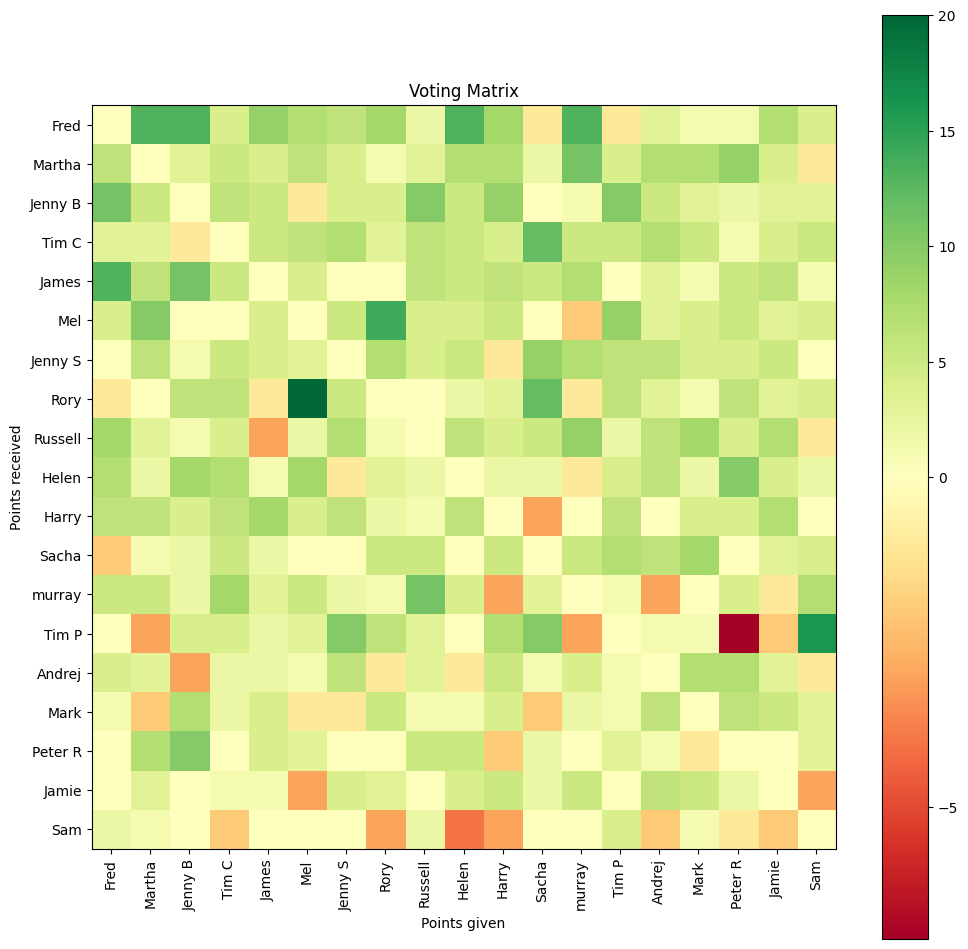

In [158]:
fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_matrix),
                        vcenter=0,
                        vmax=np.max(voting_matrix))

plt.imshow(voting_matrix, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.xlabel("Points given")
plt.ylabel("Points received")
plt.title("Voting Matrix")


cbar = plt.colorbar()

plt.show()

In [159]:
# Biggest differences 

reciprocals = np.abs((np.triu(voting_matrix) - np.tril(voting_matrix).T))
diffs = np.unravel_index(np.argsort(reciprocals.reshape(-1))[::-1][:10], reciprocals.shape)

for row, col in zip(*diffs):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

Sam for Tim P: 16
Mark for Sacha: 8
Peter R for Tim P: -7
Russell for James: 6
Russell for Jenny B: 10
Sacha for Jenny S: 9
Rory for Fred: 8
Mark for Martha: 7
Andrej for Jenny B: 5
Peter R for Jenny B: 2


### Biggest Stans and biggest haters

In [160]:
biggest_haters = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[::-1][:10], voting_matrix.shape)
for row, col in zip(*biggest_haters):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

Mel for Rory: 20
Sam for Tim P: 16
Rory for Mel: 14
Jenny B for Fred: 13
Martha for Fred: 13
Helen for Fred: 13
murray for Fred: 13
Fred for James: 13
Sacha for Tim C: 12
Sacha for Rory: 12


In [161]:
biggest_haters = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[:10], voting_matrix.shape)
for row, col in zip(*biggest_haters):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

Peter R for Tim P: -7
Helen for Sam: -4
Harry for murray: -3
Mel for Jamie: -3
Jenny B for Andrej: -3
murray for Tim P: -3
Andrej for murray: -3
Martha for Tim P: -3
Sacha for Harry: -3
Harry for Sam: -3


## Voting Correlation

This shows who votes similarly, and who doesn't. Note that the matrix is symmetrical

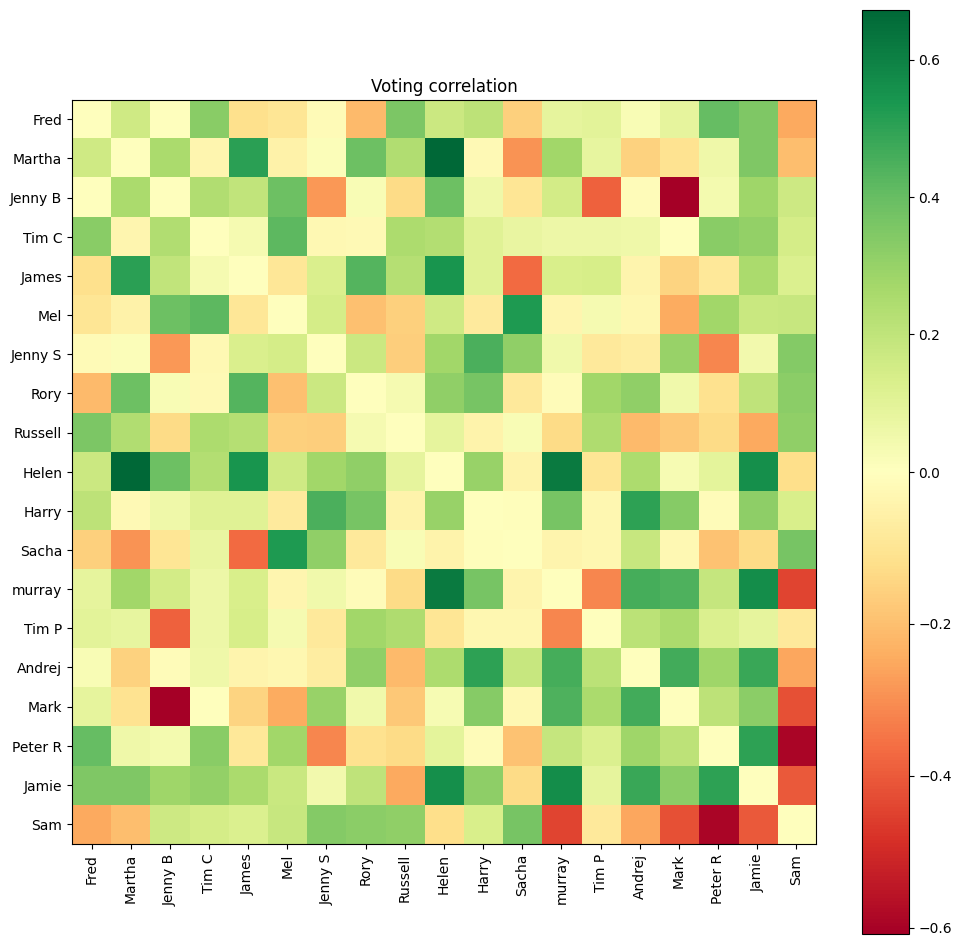

In [162]:
# Sort arr into an array that's lists of each competitors votes per round

voting_correlation = np.corrcoef(np.vstack(voting_matrix).T)
np.fill_diagonal(voting_correlation, 0.0)

fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_correlation),
                        vcenter=0,
                        vmax=np.max(voting_correlation))

plt.imshow(voting_correlation, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.title("Voting correlation")


cbar = plt.colorbar()

plt.show()

### Most and least voting-correlated

In [163]:
most_correlated = np.unravel_index(np.argsort(-voting_correlation.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*most_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_correlation[row, col]:.2f}")

Helen and Martha: 0.67
Helen and murray: 0.62
Jamie and murray: 0.57
Jamie and Helen: 0.56
Helen and James: 0.54
Mel and Sacha: 0.53
Martha and James: 0.51
Andrej and Harry: 0.50
Peter R and Jamie: 0.50
Andrej and Jamie: 0.48


In [164]:
least_correlated = np.unravel_index(np.argsort(voting_correlation.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*least_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_correlation[row, col]:.2f}")

Jenny B and Mark: -0.61
Sam and Peter R: -0.59
Sam and murray: -0.44
Sam and Mark: -0.42
Jamie and Sam: -0.40
Tim P and Jenny B: -0.39
James and Sacha: -0.37
Jenny S and Peter R: -0.32
Tim P and murray: -0.31
Martha and Sacha: -0.29


## Genre Correlation

See who submitted similar genres. Note that Spotify's list of genres is pretty wild, so this is pretty rough

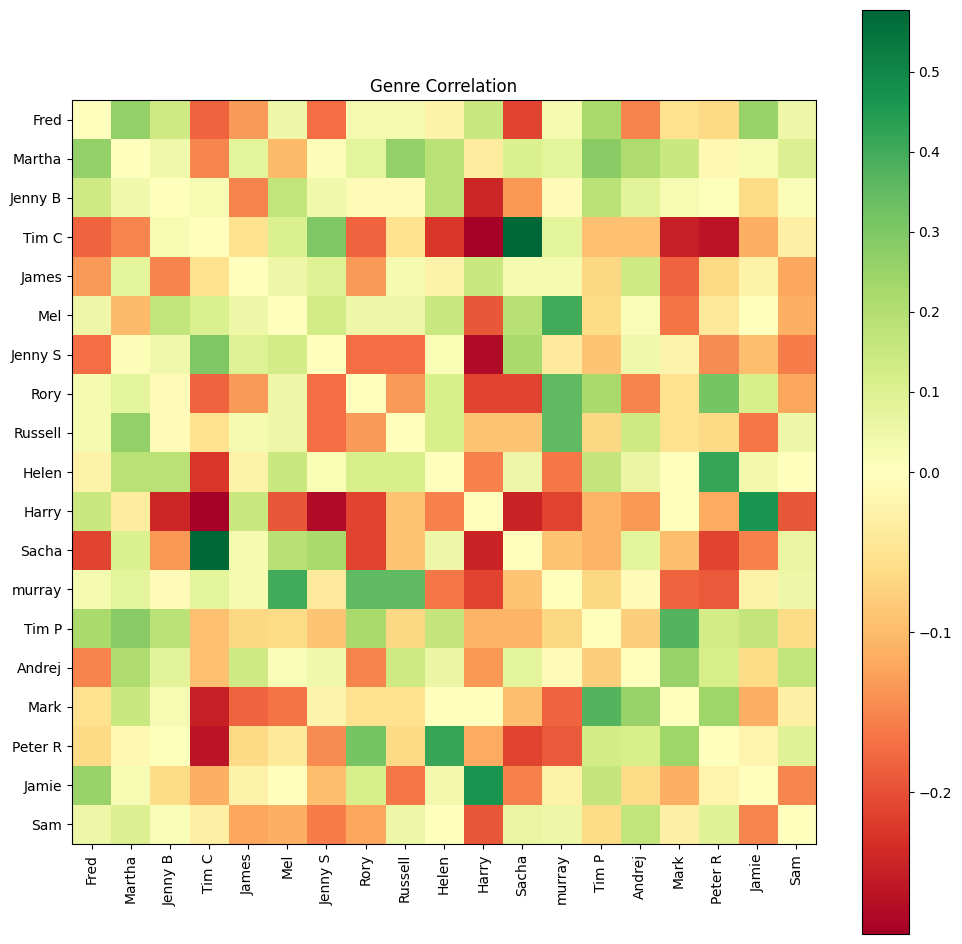

In [165]:
unique_genres = set()

for submitter in winning_order:
    rest = set(reduce(add, df[df.submitter != submitter]["genres"].values))
    unique_genres |= set(reduce(add, df[df.submitter == submitter]["genres"])).difference(rest)

all_genres = list({genre for genres in df.genres for genre in genres}.difference(unique_genres))

x = df.groupby("submitter")["genres"].apply(lambda x: reduce(add, x)).reindex(winning_order).map(set)

genre_matrix = np.zeros((len(winning_order), len(all_genres)))

for i, genres in enumerate(x.values):
    for j, genre in enumerate(all_genres):
        if genre in genres:
            genre_matrix[i][j] = 1.0

voting_matrix = np.corrcoef(genre_matrix)
np.fill_diagonal(voting_matrix, 0.0)

fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_matrix),
                        vcenter=0,
                        vmax=np.max(voting_matrix))

plt.imshow(voting_matrix, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.title("Genre Correlation")


cbar = plt.colorbar()

plt.show()

### Most and least genre correlated

In [166]:
most_genre_correlated = np.unravel_index(np.argsort(-voting_matrix.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*most_genre_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_matrix[row, col]:.2f}")

Sacha and Tim C: 0.58
Jamie and Harry: 0.46
Helen and Peter R: 0.42
murray and Mel: 0.40
Mark and Tim P: 0.37
Russell and murray: 0.35
Rory and murray: 0.35
Peter R and Rory: 0.31
Jenny S and Tim C: 0.30
Tim P and Martha: 0.28


In [167]:
least_genre_correlated = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*least_genre_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_matrix[row, col]:.2f}")

Harry and Tim C: -0.29
Jenny S and Harry: -0.27
Peter R and Tim C: -0.26
Tim C and Mark: -0.25
Sacha and Harry: -0.24
Jenny B and Harry: -0.24
Helen and Tim C: -0.22
Peter R and Sacha: -0.21
Harry and Rory: -0.21
Rory and Sacha: -0.21


## Average positive vote given out

Look at who chunks their votes into lumps vs those who scatter their votes like chicken feed

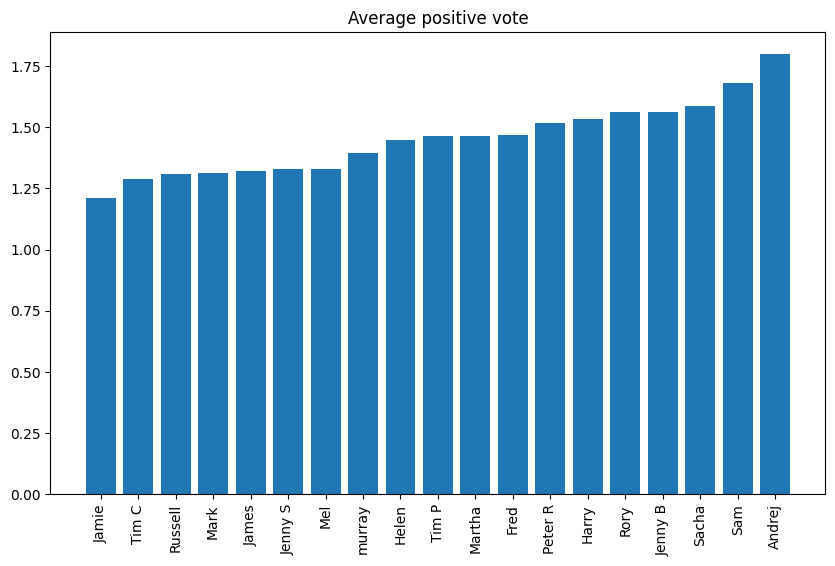

In [168]:
x = arr.reshape(-1, len(winning_order))
x[x <= 0.0] = np.nan
a = np.nanmean(x, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Average positive vote")

ax.bar(np.arange(len(winning_order)), a[np.argsort(a)])
ax.set_xticks(np.arange(len(winning_order)), labels=[winning_order[i] for i in np.argsort(a)], rotation="vertical")

plt.show()

## Average song age

Plot every players average song age with respect to today (or when this notebook was run). Note that the accuracy of date on some songs is worse than others (year vs month vs day, so this isn't 100% accurate)

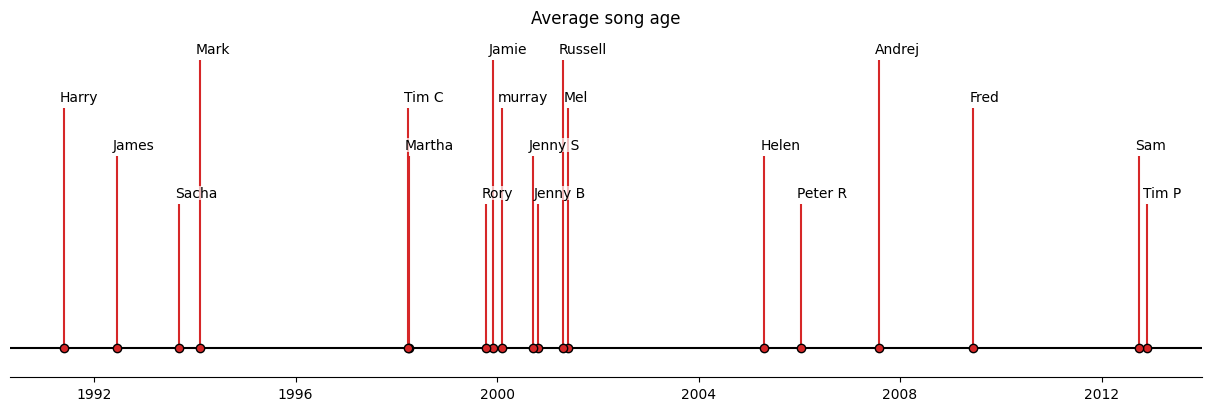

In [169]:
df["song_age_seconds"] = (datetime.now() - df["release_date"]).dt.total_seconds()
ages = df.groupby("submitter")["song_age_seconds"].mean().sort_values().map(lambda x: datetime.now() - timedelta(seconds=x))

fig, ax = plt.subplots(figsize=(12, 4), layout="constrained")
ax.set(title="Average song age")

levels = [(i % 4) / 3 + 1 for i in range(len(ages))]

# The vertical stems.
ax.vlines(ages, 0, levels,
          color=[("tab:red", 1)
                 for _ in ages])
# The baseline.
ax.axhline(0, c="black")
# The markers on the baseline
ax.plot(ages, np.zeros_like(ages), "ko", mfc="tab:red")

# Annotate the lines.
for date, level, name in zip(ages, levels, ages.index):
    ax.annotate(name, xy=(date, level),
                xytext=(-3, np.sign(level)*3), textcoords="offset points",
                verticalalignment="bottom" if level > 0 else "top",
                bbox=dict(boxstyle='square', pad=0, lw=0, fc=(1, 1, 1, 0.7)))

ax.yaxis.set(major_locator=mdates.YearLocator(),
             major_formatter=mdates.DateFormatter("%Y"))

# Remove the y-axis and some spines.
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.show()

In [170]:
oldest = df.groupby("submitter")["song_age_seconds"].max().apply(lambda x: datetime.now() - timedelta(seconds=x)).sort_values()
youngest = df.groupby("submitter")["song_age_seconds"].min().apply(lambda x: datetime.now() - timedelta(seconds=x)).sort_values()

oldest_oldest = df.iloc[df[df["submitter"] == oldest.index[0]]["song_age_seconds"].idxmax()][["submitter", "release_date", "song_name"]]
youngest_oldest = df.iloc[df[df["submitter"] == oldest.index[-1]]["song_age_seconds"].idxmax()][["submitter", "release_date", "song_name"]]
youngest_youngest = df.iloc[df[df["submitter"] == youngest.index[-1]]["song_age_seconds"].idxmin()][["submitter", "release_date", "song_name"]]
oldest_youngest = df.iloc[df[df["submitter"] == youngest.index[0]]["song_age_seconds"].idxmin()][["submitter", "release_date", "song_name"]]

print(oldest_youngest.to_list())


['Tim C', Timestamp('2017-09-21 00:00:00'), 'This Town (feat. Sasha Alex Sloan)']


In [171]:
# does song age correlate with overall position

np.corrcoef(np.c_[ages.reindex(winning_order).argsort(), np.arange(len(ages))].T)

array([[1.        , 0.20877193],
       [0.20877193, 1.        ]])

### Mean song length

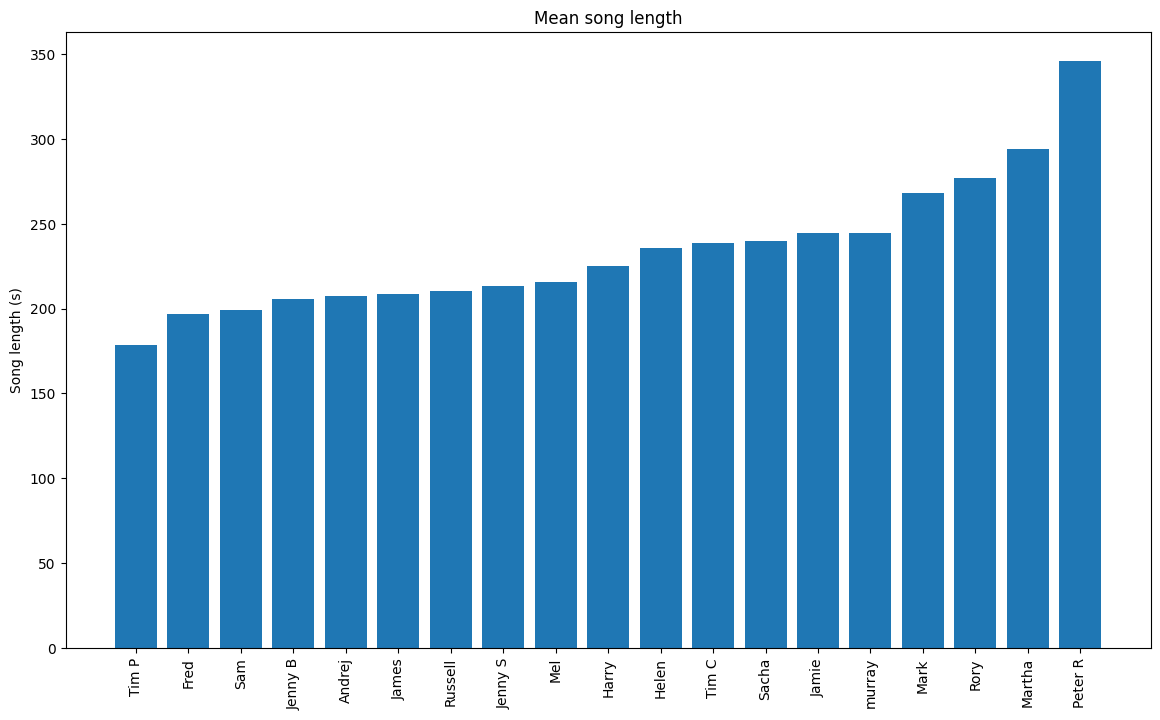

In [172]:
lengths = df.groupby("submitter")["duration_s"].mean().sort_values()

fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(np.arange(len(lengths)), lengths)
ax.set_xticks(np.arange(len(winning_order)), lengths.index, rotation='vertical')
ax.set_title("Mean song length")
ax.set_ylabel("Song length (s)")
plt.show()

In [173]:
# Correlation between mean song length and overall league rank
np.corrcoef(lengths.reindex(winning_order).rank(), np.arange(1, len(winning_order)+1))


array([[1.        , 0.14912281],
       [0.14912281, 1.        ]])

### Longest and shortest songs

In [174]:
df.sort_values("duration_s", ascending=False)[["submitter", "song_name", "duration_s"]].iloc[:10]

,submitter,song_name,duration_s
7,Peter R,"Polovtsian Dances From ""Prince Igor""",690.306
147,Rory,Black No. 1 (Little Miss Scare -All),675.653
183,Peter R,"Ghandi, Dalai Lama, Your Lord & Savior J.C. / ...",615.028
53,Mark,I Love You... I'll Kill You,532.560
62,Jamie,Purple Rain,521.866
70,Martha,Deacon Blues,455.497
58,Helen,Blue Monday,449.160
131,Tim C,Fear of the Dark - 2015 Remaster,438.120
56,Peter R,yellow is the color of her eyes,435.080
165,Peter R,The Place Where He Inserted the Blade,433.360


In [175]:
df.sort_values("duration_s", ascending=True)[["submitter", "song_name", "duration_s"]].iloc[:10]

,submitter,song_name,duration_s
54,Tim P,Swiper No Swiping!,46.106
14,Tim P,Mission: Impossible Theme,51.800
16,James,The Best A Man Can Get (Gillette),60.000
18,Sam,Duncan Hills Coffee Jingle,74.933
173,Andrej,Tim I Wish You Were Born a Girl,106.533
175,Harry,John & James,125.266
105,Fred,My Barn My Rules - Edit,126.530
115,Fred,Guns and Ships,127.578
144,Tim P,"Spooky, Scary Skeletons",127.626
36,Mark,Universal Soldier,133.573


## Rankings if only downvotes/upvotes counted

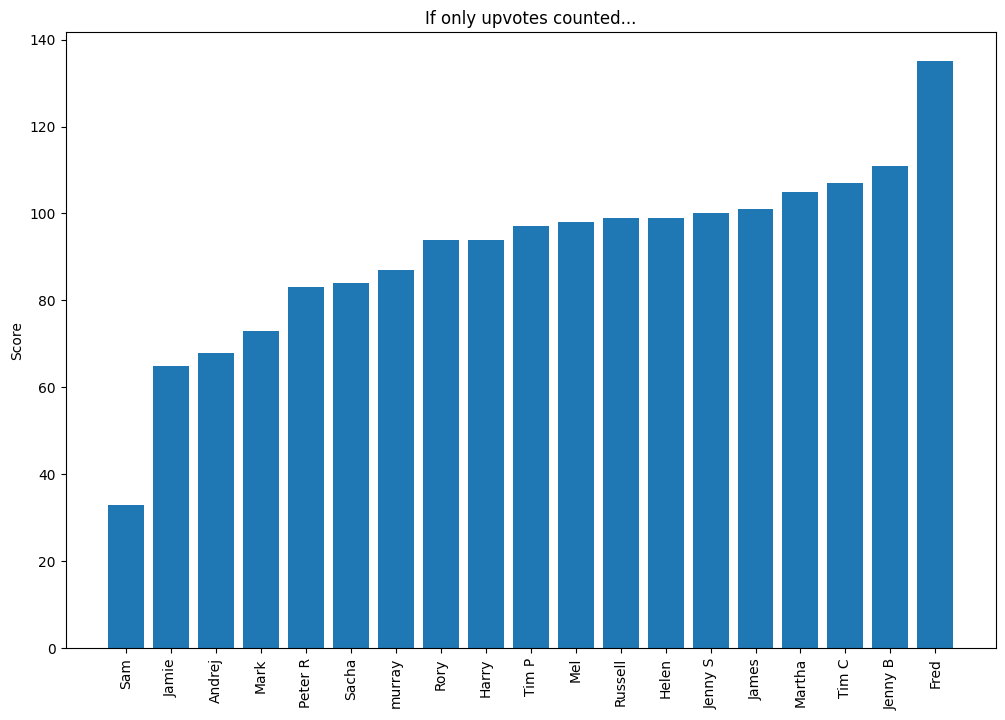

In [176]:
positive_votes = np.where(arr > 0, arr, 0)

positive_scores = np.sum(positive_votes, axis=(0, 2))

order = np.argsort(positive_scores)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(np.arange(len(winning_order)), np.sort(positive_scores))
ax.set_xticks(range(len(winning_order)), [winning_order[i] for i in order], rotation="vertical")
ax.set_ylabel("Score")
ax.set_title("If only upvotes counted...")

plt.show()

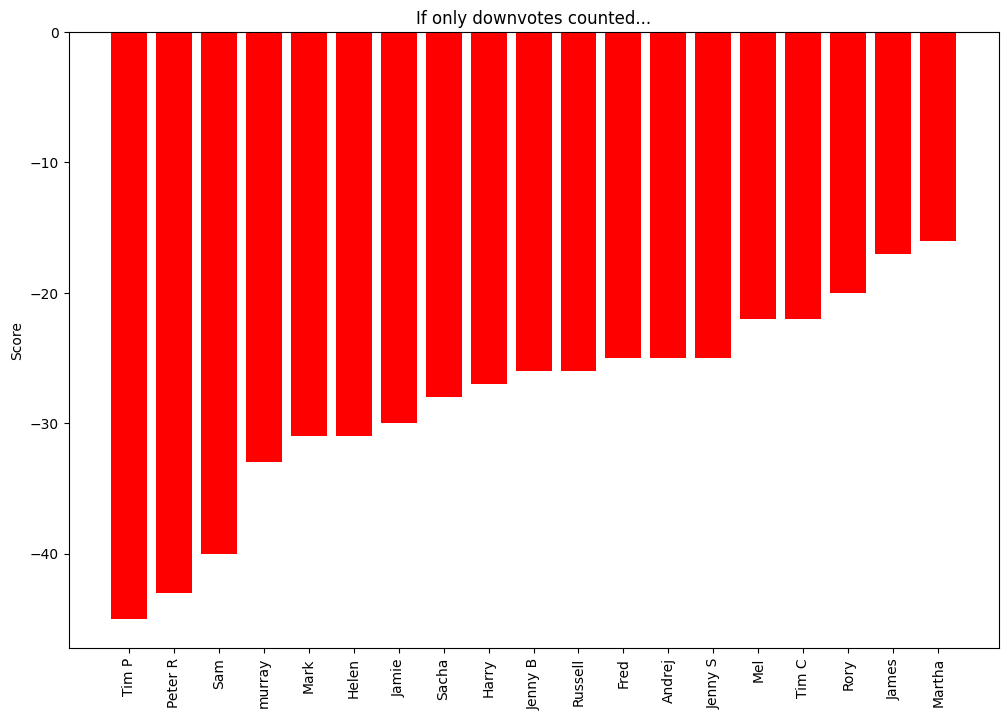

In [177]:
negative_votes = np.where(arr < 0, arr, 0)

negative_scores = np.sum(negative_votes, axis=(0, 2))

order = np.argsort(negative_scores)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(np.arange(len(winning_order)), np.sort(negative_scores), color="red")
ax.set_xticks(range(len(winning_order)), [winning_order[i] for i in order], rotation="vertical")
ax.set_ylabel("Score")
ax.set_title("If only downvotes counted...")

plt.show()

## Controversy score

The controversy score aims to find the most controversial songs, those with the highest numbers of upvotes and downvotes leaving a score near 0

The controversy score $C$ is calculated using the following formula:


$C = \sqrt{\frac{1}{N_{\neq 0}} \sum_{i=1}^{N_{\neq 0}} (v_i - \mu)^2} \times \left( \sum_{i=1}^{n} v_i \text{ where } v_i > 0 \ - \ \alpha \sum_{i=1}^{n} v_i \text{ where } v_i < 0 \right)$


Where:
- $v_i$ are the individual votes.
- $\mu$ is the mean of the non-zero votes.
- $N_{\neq 0}$ is the number of non-zero votes.
- $\alpha$ is the ratio of positive to negative votes ($\frac{10}{3}$ in this league)
- The first part of the equation represents the standard deviation of the non-zero votes.
- The second part represents a modified range that accounts for positive and scaled negative votes.


/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


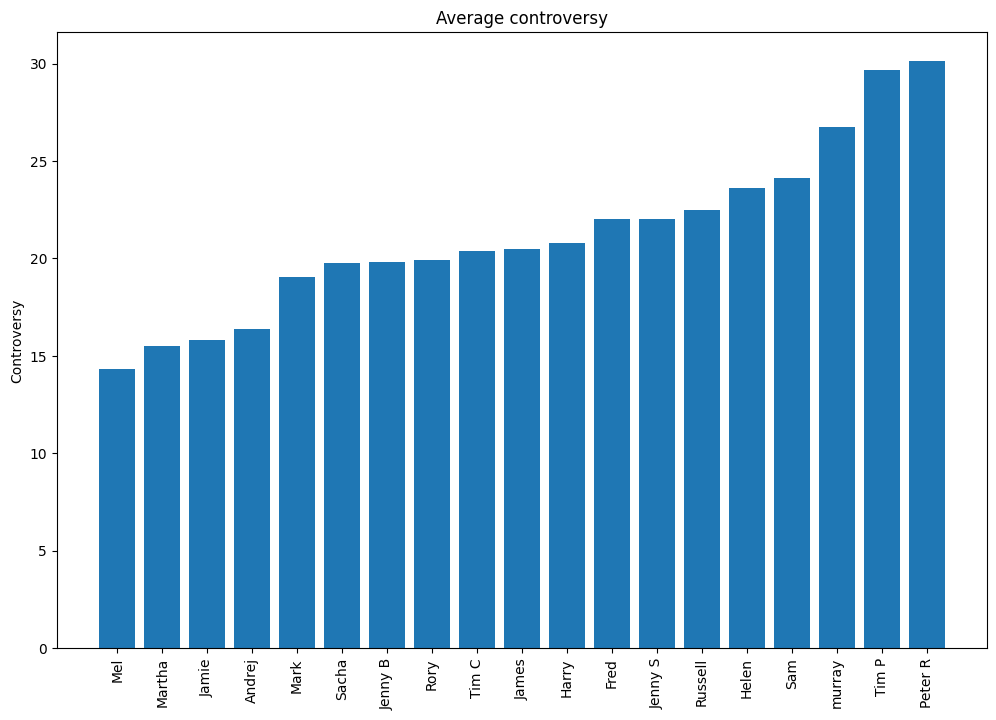

In [178]:
def controversy(vals):
    std = np.std([i for i in vals if i])
    range = sum(i for i in vals if i > 0.0) - (sum(i for i in vals if i < 0.0) * 10/3)
    return std * range

df["controversy"] = df[names].fillna(0).apply(controversy, axis=1)
df.sort_values("controversy", ascending=False)[["submitter", "song_name", "round", "controversy"]].iloc[:10]

fig, ax = plt.subplots(figsize=(12, 8))

vals = df.groupby("submitter")["controversy"].mean().sort_values()

ax.bar(np.arange(len(vals)), vals)
ax.set_xticks(range(len(vals)), vals.index, rotation="vertical")
ax.set_ylabel("Controversy")
ax.set_title("Average controversy")

plt.show()

In [179]:
df.sort_values("controversy", ascending=False)[["controversy", "submitter", "round", "song_name"]].iloc[:10]

,controversy,submitter,round,song_name
74,116.833214,Sam,Colours 🎨,"Love Me Like You Do (From ""50 Shades of Grey"")..."
127,71.527709,murray,Musicals 🎭,Hard Candy Christmas
93,61.884619,Tim P,Duets 🎤,Harry Potter vs Luke Skywalker
159,54.681648,Sacha,Spotify wrapped tracks 🎁,Never Gonna Give You Up
183,53.108716,Peter R,URTEK names 📛,"Ghandi, Dalai Lama, Your Lord & Savior J.C. / ..."
51,52.923775,Helen,Breaking the law 🕵️‍♀️,Kill V. Maim
72,49.949797,Tim P,Colours 🎨,It's Corn
79,48.325496,Russell,Duets 🎤,Forgot About Dre
126,44.895248,Jamie,Musicals 🎭,Six
95,44.311196,Jenny S,Guilty pleasures 👀,Hotel Room Service


In [180]:
print("Number of explicit songs submitted")
df.groupby("submitter")["explicit"].sum().sort_values(ascending=False)

Number of explicit songs submitted


submitter
Russell    3
murray     2
Fred       2
Tim P      2
Jenny S    1
Rory       1
Jenny B    1
Sam        1
Tim C      1
Harry      0
Andrej     0
Mel        0
Martha     0
Mark       0
Jamie      0
Helen      0
James      0
Sacha      0
Peter R    0
Name: explicit, dtype: int64

In [181]:
# Every explicit song
df[df["explicit"]][["submitter", "round", "song_name", "artist_names"]]

,submitter,round,song_name,artist_names
18,Sam,Advert songs 📺,Duncan Hills Coffee Jingle,[Metalocalypse: Dethklok]
28,Russell,Back to basics 🎸,Thatcher Fucked the Kids,[Frank Turner]
29,Tim P,Back to basics 🎸,Inflatable You - Live,[Tim Minchin]
43,Fred,Breaking the law 🕵️‍♀️,450,"[Bad Boy Chiller Crew, S Dog]"
46,Jenny S,Breaking the law 🕵️‍♀️,Break Stuff,[Limp Bizkit]
57,Fred,Colours 🎨,Redbone,[Childish Gambino]
79,Russell,Duets 🎤,Forgot About Dre,"[Dr. Dre, Eminem]"
98,Tim C,Guilty pleasures 👀,Last Resort,[Papa Roach]
142,Russell,Sp00ky 👻,vampire,[Olivia Rodrigo]
147,Rory,Sp00ky 👻,Black No. 1 (Little Miss Scare -All),[Type O Negative]
